# preprocessing

In [1]:
import os
import pandas as pd
import librosa
import numpy as np
import pickle

## read data 


In [55]:
import os
import librosa
import pandas as pd

data_dir = r'..\data\big_data\4'
# Allowed base names
allowed_basenames = {'words', 'text', 'random'}
allowed_basenames = {'text', }


audio_data = []
press_times = []  # To store the corresponding event data

shift = 0.042  # Shift in seconds

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.wav'):
        # Get the base name (without extension)
        base_name = os.path.splitext(filename)[0]
        
        # Only process if the base name is one of the allowed names
        if base_name not in allowed_basenames:
            continue
        
        wav_filepath = os.path.join(data_dir, filename)
        # Construct the corresponding text file name
        txt_filename = f"{base_name}.txt"
        txt_filepath = os.path.join(data_dir, txt_filename)
        
        # Check if the event file exists
        if not os.path.exists(txt_filepath):
            print(f"Warning: Event file '{txt_filename}' is missing for audio file '{filename}'.")
            continue
        
        # Load the audio file
        try:
            audio, sr = librosa.load(wav_filepath, sr=None)  # load with original sampling rate
        except Exception as e:
            print(f"Error loading audio file '{filename}': {e}")
            continue
        
        # Load the event file (only first two columns: timestamp and event_type)
        try:
            df = pd.read_csv(txt_filepath, header=None, usecols=[0, 1],
                             names=['timestamp', 'event_type'])
        except Exception as e:
            print(f"Error reading event file '{txt_filename}': {e}")
            continue
        
        # Filter only the "down" events (where event_type == 0)
        df = df[df['event_type'] == 0]
        
        # Divide the timestamp by 1e7
        df['timestamp'] = df['timestamp'] / 1e7 + shift
        
        # Append the loaded data
        audio_data.append((audio, sr))
        press_times.append(df)


In [15]:
len(press_times)

3

## feature extraction (melspectrogram)

In [56]:
def extract_features(audio, sr, n_mels=64, hop_length=512):
    """
    Extracts Mel spectrogram features from audio.
    
    Parameters:
    - audio: Audio signal (numpy array)
    - sr: Sampling rate of the audio
    - n_mels: Number of Mel bands
    - hop_length: Number of samples between successive frames
    
    Returns:
    - mel_spectrogram: Mel spectrogram features
    - times_ms: Times of each frame in milliseconds
    """
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Convert frames to time in milliseconds
    times = librosa.frames_to_time(np.arange(mel_spectrogram_db.shape[1]), sr=sr, hop_length=hop_length)
    # times_ms = times * 1000  # Convert to milliseconds
    times_ms = times
    
    return mel_spectrogram_db, times_ms

# Extract features for each audio file
features = []
times_list = []
for (audio, sr), timestamps in zip(audio_data, press_times):
    mel_features, times_ms = extract_features(audio, sr)
    features.append(mel_features)
    times_list.append(times_ms)

## show one example 

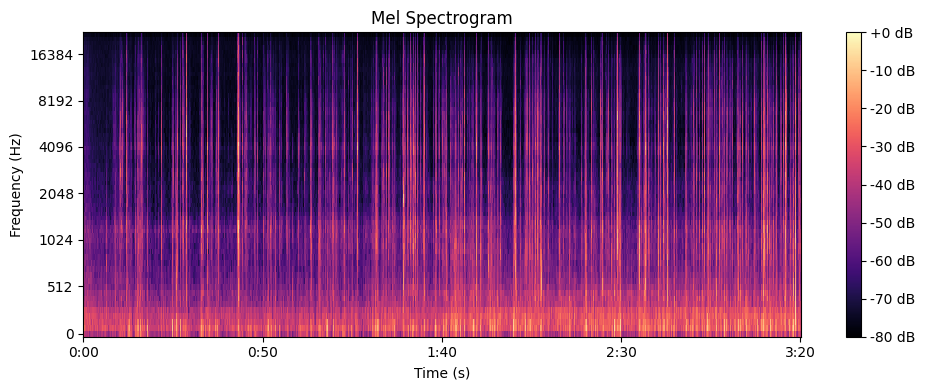

In [58]:
import matplotlib.pyplot as plt
import librosa.display

# Choose an example to plot (e.g., the first one)
example_mel_spectrogram = features[0]  # Change index if you want to see a different one

# Plotting the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(example_mel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## data labeling

In [59]:
def label_audio(times_ms, timestamps, window_size=50):
    """
    Labels each time frame in the audio based on key press timestamps.
    
    Parameters:
    - times_ms: Times of each frame in milliseconds
    - timestamps: DataFrame with key press times
    - window_size: Time window in milliseconds to mark a key press as "active"
    
    Returns:
    - labels: Binary labels (1 for key press, 0 for no key press) for each frame
    """
    labels = np.zeros(len(times_ms))
    press_times = timestamps['timestamp'].values  # Assuming column is 'time_in_ms'

    window_size = times_ms[1] - times_ms[0]
    
    for press_time in press_times:
        # Find frames within the window around the key press time
        window_start = press_time - window_size / 2
        window_end = press_time + window_size / 2
        active_frames = np.where((times_ms >= window_start) & (times_ms <= window_end))[0]
        
        # Label those frames as 1 (key pressed)
        labels[active_frames] = 1
    
    return labels

# Label the data
labels = []
for times_ms, timestamps in zip(times_list, press_times):
    labels.append(label_audio(times_ms, timestamps))

In [60]:
len(features[0])

64

In [61]:
features[0].shape

(64, 17236)

In [62]:
def create_training_windows(features, labels, window_size=25):
    """
    Segments features and labels into training windows.
    
    Parameters:
    - features: Mel spectrogram features
    - labels: Binary labels for each frame
    - window_size: Number of frames in each training window
    
    Returns:
    - X: List of feature windows
    - y: List of corresponding label windows
    """
    X, y = [], []
    for i in range(0, len(features) - window_size, window_size):
        X.append(features[:, i:i + window_size])
        y.append(labels[i:i + window_size])
    
    return np.array(X), np.array(y)

# Generate training windows for each audio file
X_train, y_train = [], []
for mel_features, label in zip(features, labels):
    X, y = create_training_windows(mel_features, label)
    X_train.append(X)
    y_train.append(y)

# Stack all windows into a single array
X_train = np.vstack(X_train)
y_train = np.hstack(y_train)


In [41]:
X_train.shape, y_train.shape

((6, 64, 25), (2, 75))

In [63]:
def prepare_framewise_data(features, labels):
    """
    Flattens each time step of the Mel spectrogram into an independent training sample.
    
    Parameters:
    - features: List of Mel spectrograms (one per audio sample)
    - labels: List of binary label arrays (one per audio sample)
    
    Returns:
    - X: 2D array where each row is a frame (frequency bins) from all audio samples
    - y: 1D array with binary labels for each frame
    """
    X, y = [], []
    
    for mel_features, label in zip(features, labels):
        # Flatten along time axis
        X.append(mel_features.T)  # Transpose so each row is a time frame (n_mels,)
        y.append(label)
    
    # Concatenate all frames and labels into single arrays
    X = np.vstack(X)
    y = np.hstack(y)
    
    return X, y

# Prepare the frame-wise data
X_train, y_train = prepare_framewise_data(features, labels)

# Save the data to disk
output_dir = r'../data/model_data'
np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)

# Alternative: Saving as pickle
with open(os.path.join(output_dir, 'training_data.pkl'), 'wb') as f:
    pickle.dump((X_train, y_train), f)

print("Data saved successfully.")

Data saved successfully.


In [44]:
X_train.shape

(38029, 64)

In [45]:
y_train.shape   

(38029,)

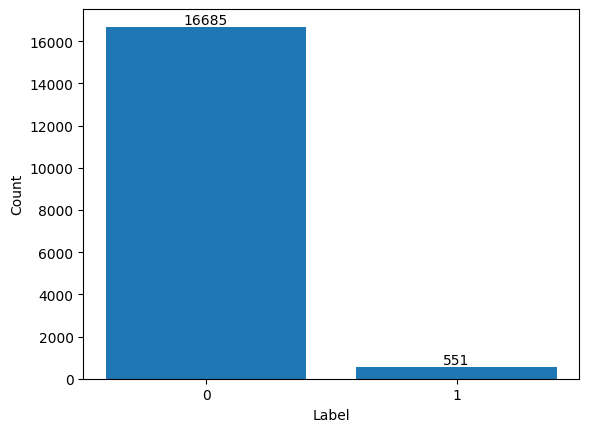

In [64]:
# plot a bar chart that counts the number of 1s and 0s in the y_train array

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, tick_label=[0, 1])

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(unique[i], count, str(count), ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')

plt.show()


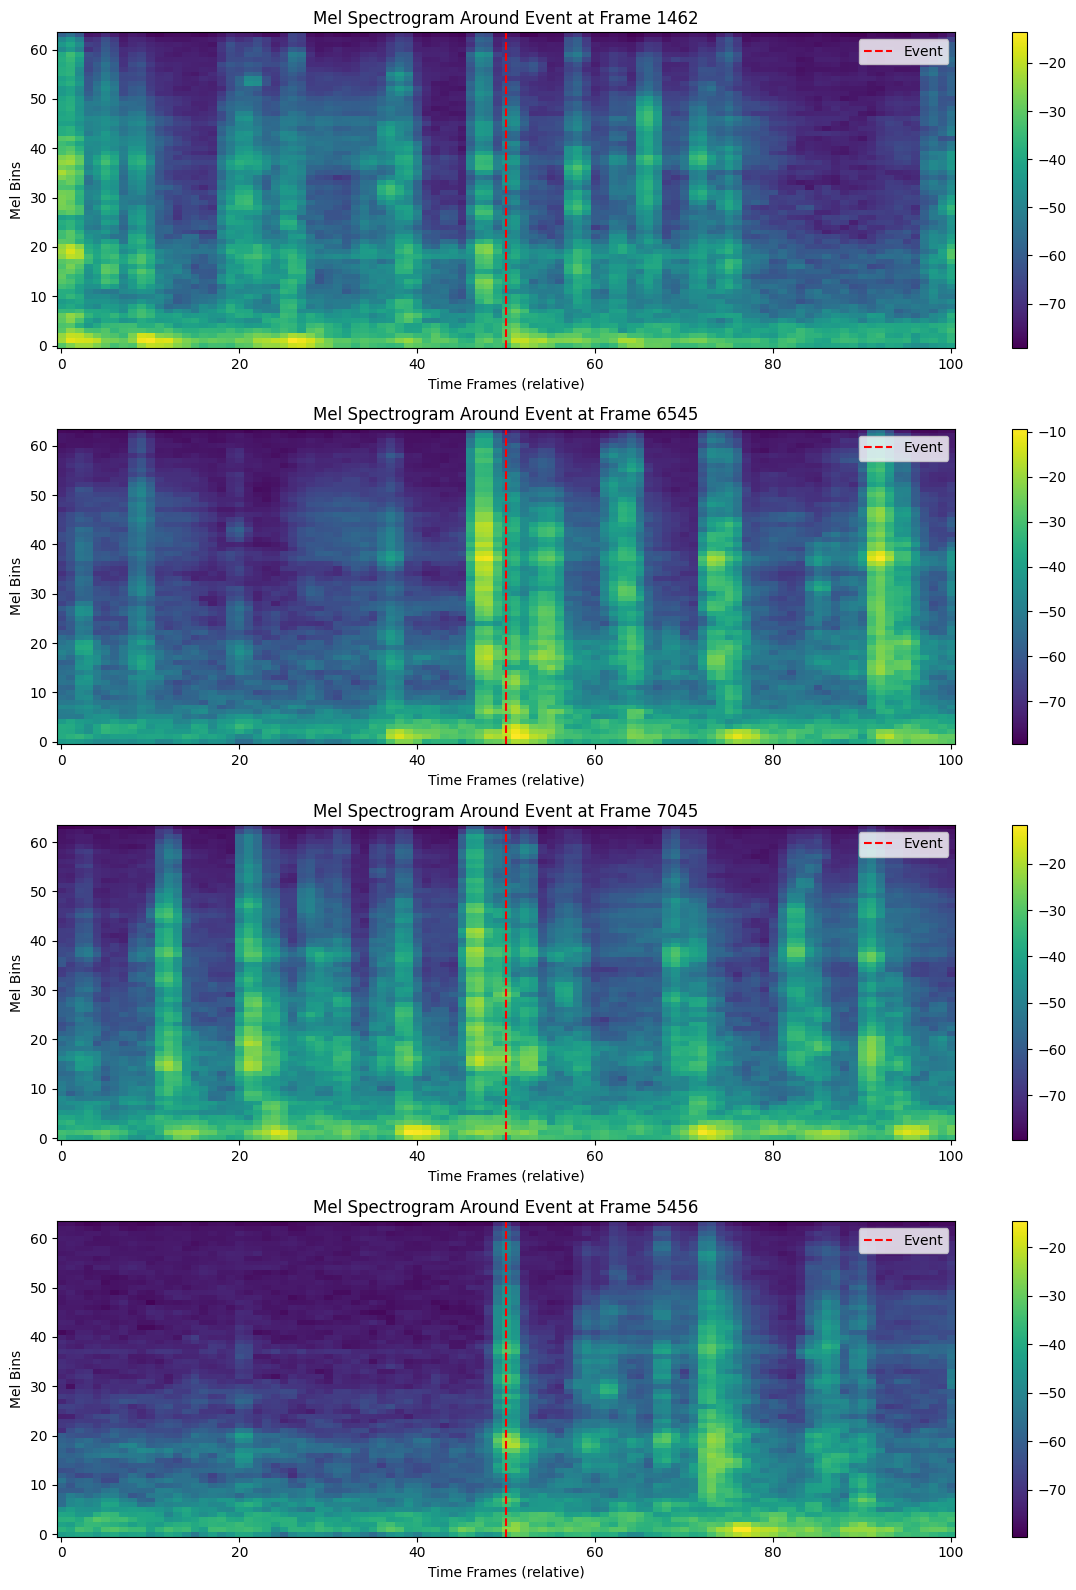

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train is a NumPy array of shape (38029, 64) with mel spectrogram features
# and y_train is a NumPy array of shape (38029,) with binary labels (1 for event, 0 for non-event).

# Find all indices where y_train is 1 (i.e., event positions)
event_indices = np.where(y_train == 1)[0]

# If there are fewer than 4 events, use all of them; otherwise, sample 4 randomly.
if len(event_indices) < 4:
    print("Less than 4 positive events found; using all available events.")
    sample_indices = event_indices
else:
    sample_indices = np.random.choice(event_indices, size=4, replace=False)

# Set the window size: number of frames before and after the event to include.
window_size = 50  # Adjust this as needed.

# Set up the subplots to display each spectrogram snippet.
n_samples = len(sample_indices)
fig, axes = plt.subplots(n_samples, 1, figsize=(12, 4 * n_samples))

# If only one subplot is returned, wrap it in a list.
if n_samples == 1:
    axes = [axes]

for ax, target_index in zip(axes, sample_indices):
    # Determine start and end indices for the snippet.
    start_idx = max(0, target_index - window_size)
    end_idx = min(X_train.shape[0], target_index + window_size + 1)
    
    # Extract the snippet from X_train.
    snippet = X_train[start_idx:end_idx, :]
    
    # Plot the mel spectrogram snippet.
    # Transpose so that the mel bins appear on the y-axis and time frames on the x-axis.
    im = ax.imshow(snippet.T, aspect='auto', origin='lower', interpolation='nearest')
    
    # Mark the event within the snippet.
    relative_event_index = target_index - start_idx
    ax.axvline(x=relative_event_index, color='red', linestyle='--', label='Event')
    
    # Set plot titles and labels.
    ax.set_title(f"Mel Spectrogram Around Event at Frame {target_index}")
    ax.set_xlabel("Time Frames (relative)")
    ax.set_ylabel("Mel Bins")
    ax.legend()
    
    # Optionally, add a colorbar.
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()


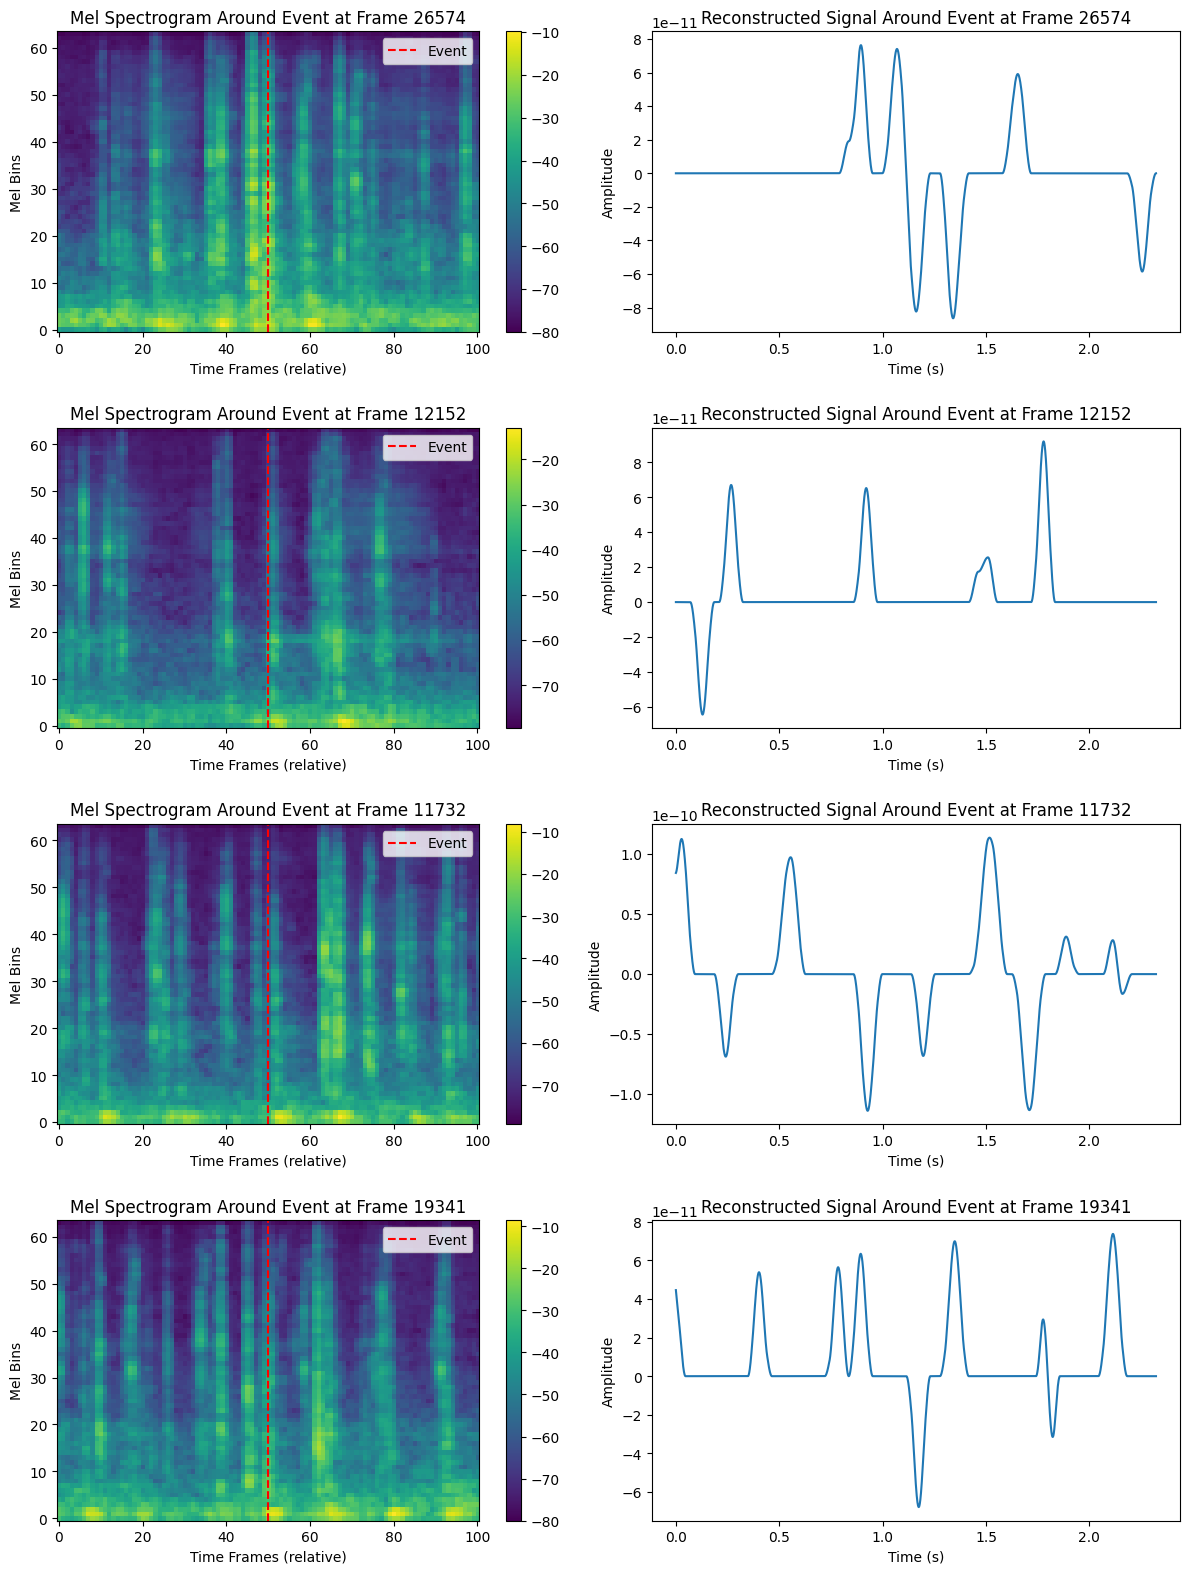

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# Example assumptions:
# X_train is a NumPy array with shape (38029, 64) representing mel spectrogram features.
# y_train is a NumPy array with shape (38029,) with binary labels (1 for event, 0 for non-event).

# Find indices where y_train equals 1 (i.e., events)
event_indices = np.where(y_train == 1)[0]

# Sample 4 events; if fewer than 4, use all available ones.
if len(event_indices) < 4:
    print("Less than 4 events found; using all available events.")
    sample_indices = event_indices
else:
    sample_indices = np.random.choice(event_indices, size=4, replace=False)

# Parameters for inversion (adjust as needed)
sample_rate = 22050   # Replace with your audio sample rate
n_fft = 2048          # FFT window size used in the original mel spectrogram computation
hop_length = 512      # Hop length used in the original mel spectrogram computation
window_size = 50      # Number of mel spectrogram frames before and after the event

# Set up subplots with 2 columns:
# - Left column: mel spectrogram snippet
# - Right column: reconstructed time-domain signal
n_samples = len(sample_indices)
fig, axes = plt.subplots(n_samples, 2, figsize=(12, 4 * n_samples))

# If there's only one sample, ensure axes is a 2D array.
if n_samples == 1:
    axes = np.expand_dims(axes, axis=0)

for i, target_index in enumerate(sample_indices):
    # Determine snippet boundaries in terms of mel spectrogram frames.
    start_idx = max(0, target_index - window_size)
    end_idx = min(X_train.shape[0], target_index + window_size + 1)
    
    # Extract the snippet (shape: [n_frames, n_mels])
    snippet = X_train[start_idx:end_idx, :]  # shape: (frames, 64)
    
    # For inversion, we want the mel spectrogram in shape (n_mels, frames)
    mel_spec_snippet = snippet.T  # shape: (64, frames)
    
    # Invert the mel spectrogram snippet to a time-domain signal.
    # This uses the Griffin–Lim algorithm, and the result is approximate.
    signal_snippet = librosa.feature.inverse.mel_to_audio(
        mel_spec_snippet, sr=sample_rate, n_fft=n_fft, hop_length=hop_length
    )
    
    # ---------------------------
    # Plot the Mel Spectrogram
    # ---------------------------
    ax_spec = axes[i, 0]
    im = ax_spec.imshow(mel_spec_snippet, aspect='auto', origin='lower',
                        interpolation='nearest')
    ax_spec.set_title(f"Mel Spectrogram Around Event at Frame {target_index}")
    ax_spec.set_xlabel("Time Frames (relative)")
    ax_spec.set_ylabel("Mel Bins")
    
    # Mark the event within the snippet with a vertical line.
    relative_event_index = target_index - start_idx
    ax_spec.axvline(x=relative_event_index, color='red', linestyle='--', label='Event')
    ax_spec.legend()
    fig.colorbar(im, ax=ax_spec, orientation='vertical')
    
    # ---------------------------
    # Plot the Reconstructed Signal
    # ---------------------------
    ax_signal = axes[i, 1]
    # Create a time axis for the signal snippet.
    times = np.linspace(0, len(signal_snippet) / sample_rate, num=len(signal_snippet))
    ax_signal.plot(times, signal_snippet)
    ax_signal.set_title(f"Reconstructed Signal Around Event at Frame {target_index}")
    ax_signal.set_xlabel("Time (s)")
    ax_signal.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


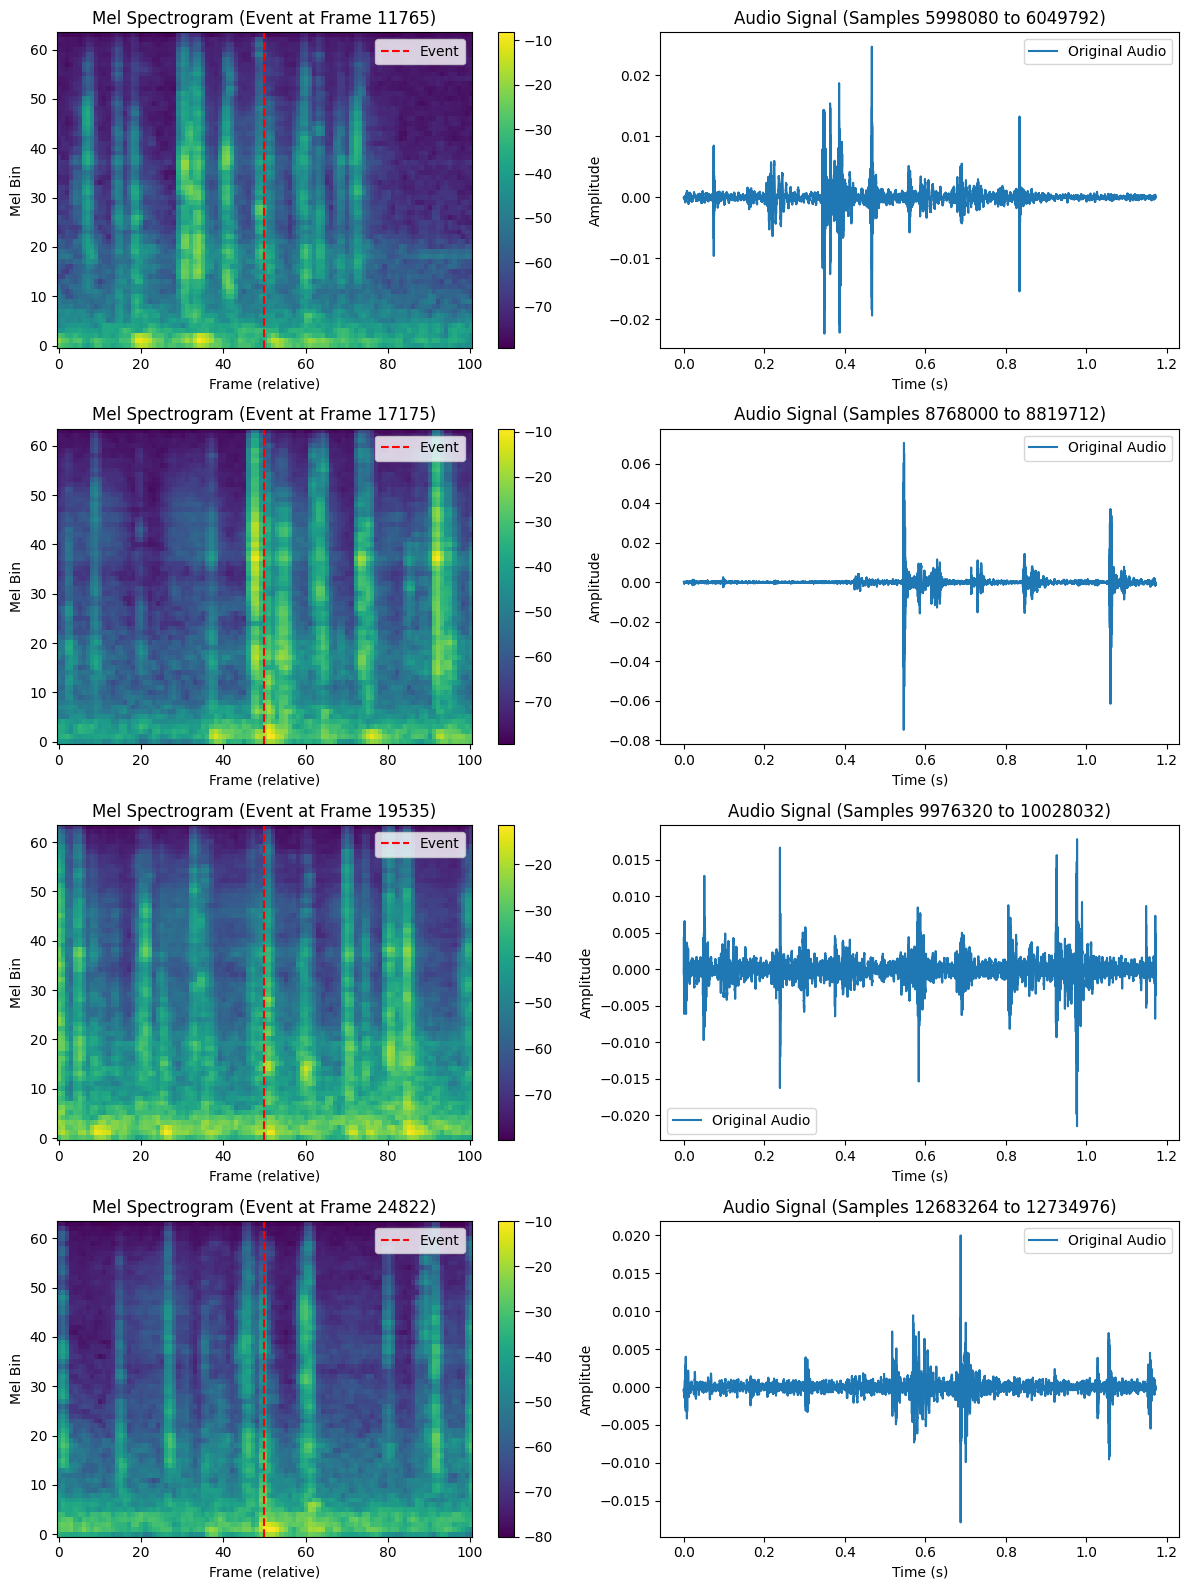

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# ----- Assumed Inputs -----
# X_train: NumPy array with shape (38029, 64) representing mel spectrogram features.
# y_train: NumPy array with shape (38029,) with binary labels (1 for event, 0 for non-event).
# audio_data: List of tuples (audio, sample_rate) from your earlier loading process.
# It is assumed that the mel spectrogram in X_train was computed from the concatenated audio.

# ----- Parameters (used for spectrogram creation) -----
n_mels = 64
hop_length = 512  # As used in your spectrogram creation
n_fft = 2048      # Adjust if necessary (should match the one used originally)

# ----- 1. Concatenate Audio Data -----
if not audio_data:
    raise ValueError("No audio data provided in audio_data list.")

# Ensure all audio segments share the same sample rate
sample_rate = audio_data[0][1]
long_audio = np.concatenate([audio for audio, sr in audio_data if sr == sample_rate])
if len(long_audio) == 0:
    raise ValueError("Concatenated audio is empty.")

# ----- 2. Sample 4 Events from y_train (label 1) -----
event_indices = np.where(y_train == 1)[0]
if len(event_indices) < 4:
    print("Fewer than 4 events found; using all available events.")
    sample_event_indices = event_indices
else:
    sample_event_indices = np.random.choice(event_indices, size=4, replace=False)

# ----- 3. Extract and Plot Snippets for Each Sampled Event -----
window_size = 50  # Number of mel spectrogram frames before and after the event

n_samples = len(sample_event_indices)
fig, axes = plt.subplots(n_samples, 2, figsize=(12, 4 * n_samples))

# If only one sample is available, ensure axes is a 2D array.
if n_samples == 1:
    axes = np.expand_dims(axes, axis=0)

for i, target_frame in enumerate(sample_event_indices):
    # --- Determine the window boundaries (in mel spectrogram frames) ---
    start_frame = max(0, target_frame - window_size)
    end_frame = min(X_train.shape[0], target_frame + window_size + 1)  # +1 to include the target frame
    
    # Extract the mel spectrogram snippet (shape: [frames, n_mels])
    snippet_mel = X_train[start_frame:end_frame, :]
    # Transpose for plotting and inversion (shape: [n_mels, frames])
    snippet_mel_T = snippet_mel.T
    
    # --- Determine corresponding audio snippet boundaries ---
    # Each mel spectrogram frame corresponds to hop_length samples in the audio.
    start_sample = start_frame * hop_length
    end_sample = min(len(long_audio), end_frame * hop_length)
    snippet_audio = long_audio[start_sample:end_sample]
    
    # Optionally, reconstruct the audio from the mel spectrogram snippet (approximate inversion)
    reconstructed_signal = librosa.feature.inverse.mel_to_audio(
        snippet_mel_T, sr=sample_rate, n_fft=n_fft, hop_length=hop_length
    )
    
    # ----- Plot the Mel Spectrogram Snippet -----
    ax_spec = axes[i, 0]
    im = ax_spec.imshow(snippet_mel_T, aspect='auto', origin='lower', interpolation='nearest')
    ax_spec.set_title(f"Mel Spectrogram (Event at Frame {target_frame})")
    ax_spec.set_xlabel("Frame (relative)")
    ax_spec.set_ylabel("Mel Bin")
    # Mark the event within the snippet (relative index)
    relative_event_index = target_frame - start_frame
    ax_spec.axvline(x=relative_event_index, color='red', linestyle='--', label='Event')
    ax_spec.legend()
    fig.colorbar(im, ax=ax_spec, orientation='vertical')
    
    # ----- Plot the Corresponding Audio Signal Snippet -----
    ax_audio = axes[i, 1]
    # Use the original audio snippet (extracted from long_audio)
    times = np.linspace(0, len(snippet_audio) / sample_rate, num=len(snippet_audio))
    ax_audio.plot(times, snippet_audio, label='Original Audio')
    # Optionally, you can also compare with the reconstructed signal:
    # times_rec = np.linspace(0, len(reconstructed_signal) / sample_rate, num=len(reconstructed_signal))
    # ax_audio.plot(times_rec, reconstructed_signal, linestyle='--', label='Reconstructed Audio')
    
    ax_audio.set_title(f"Audio Signal (Samples {start_sample} to {end_sample})")
    ax_audio.set_xlabel("Time (s)")
    ax_audio.set_ylabel("Amplitude")
    ax_audio.legend()

plt.tight_layout()
plt.show()


[ 3907  8034 12877 14792]


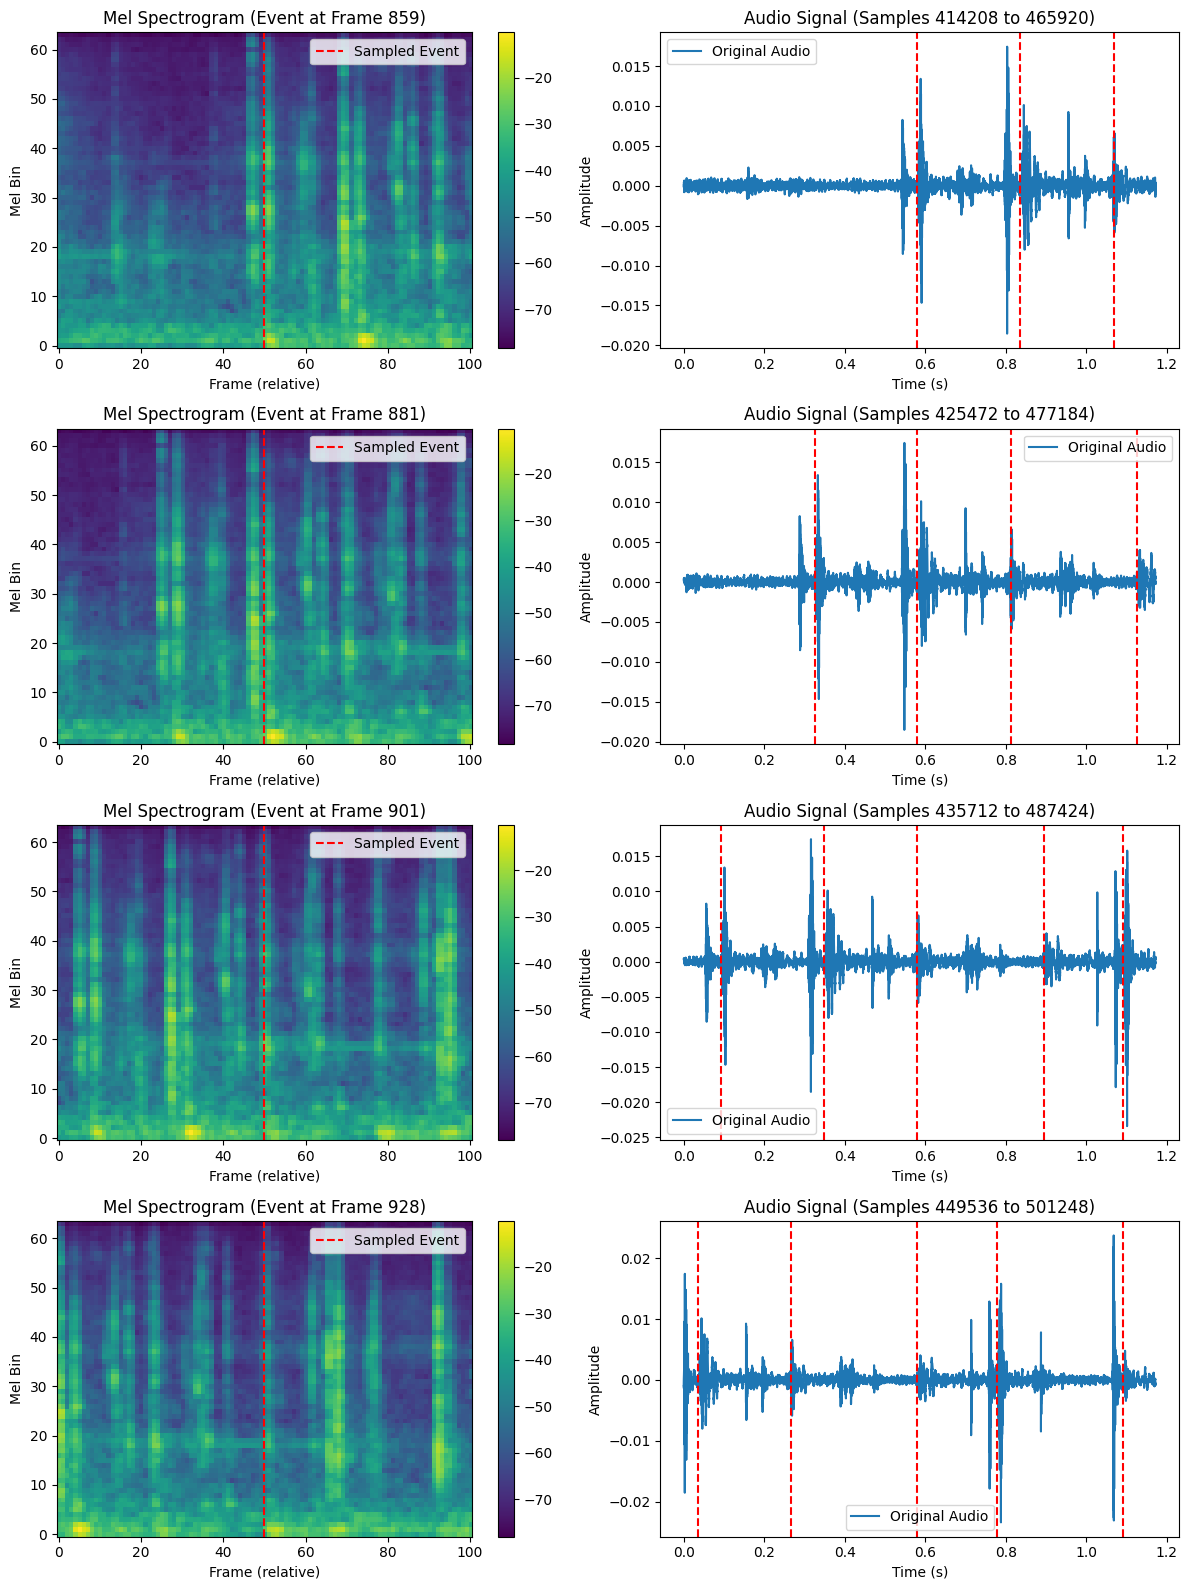

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# ----- Assumed Inputs -----
# X_train: NumPy array with shape (38029, 64) representing mel spectrogram features.
# y_train: NumPy array with shape (38029,) with binary labels (1 for event, 0 for non-event).
# audio_data: List of tuples (audio, sample_rate) from your earlier loading process.
# It is assumed that the mel spectrogram in X_train was computed from the concatenated audio.

# ----- Parameters (used for spectrogram creation) -----
n_mels = 64
hop_length = 512  # as used in your spectrogram creation
n_fft = 2048      # Adjust if necessary (should match the one used originally)

# ----- 1. Concatenate Audio Data -----
if not audio_data:
    raise ValueError("No audio data provided in audio_data list.")

# Ensure all audio segments share the same sample rate.
sample_rate = audio_data[0][1]
long_audio = np.concatenate([audio for audio, sr in audio_data if sr == sample_rate])
if len(long_audio) == 0:
    raise ValueError("Concatenated audio is empty.")

# ----- 2. Sample 4 Events from y_train (label 1) -----
event_indices = np.where(y_train == 1)[0]
if len(event_indices) < 4:
    print("Fewer than 4 events found; using all available events.")
    sample_event_indices = event_indices
else:
    sample_event_indices = np.random.choice(event_indices, size=4, replace=False)
    print(sample_event_indices)
    sample_event_indices = event_indices[:4]

# ----- 3. Extract and Plot Snippets for Each Sampled Event -----
window_size = 50  # Number of mel spectrogram frames before and after the event
n_samples = len(sample_event_indices)
fig, axes = plt.subplots(n_samples, 2, figsize=(12, 4 * n_samples))

# Ensure axes is always 2D (if only one sample, wrap it in a list)
if n_samples == 1:
    axes = np.expand_dims(axes, axis=0)

for i, target_frame in enumerate(sample_event_indices):
    # --- Determine the window boundaries (in mel spectrogram frames) ---
    start_frame = max(0, target_frame - window_size)
    end_frame = min(X_train.shape[0], target_frame + window_size + 1)  # +1 to include the target frame
    
    # Extract the mel spectrogram snippet (shape: [frames, n_mels])
    snippet_mel = X_train[start_frame:end_frame, :]
    # Transpose for plotting and inversion (shape: [n_mels, frames])
    snippet_mel_T = snippet_mel.T
    
    # --- Determine corresponding audio snippet boundaries ---
    # Each mel spectrogram frame corresponds to hop_length samples in the audio.
    start_sample = start_frame * hop_length
    end_sample = min(len(long_audio), end_frame * hop_length)
    snippet_audio = long_audio[start_sample:end_sample]
    
    # Optionally, reconstruct the audio from the mel spectrogram snippet (approximate inversion)
    reconstructed_signal = librosa.feature.inverse.mel_to_audio(
        snippet_mel_T, sr=sample_rate, n_fft=n_fft, hop_length=hop_length
    )
    
    # ----- Plot the Mel Spectrogram Snippet -----
    ax_spec = axes[i, 0]
    im = ax_spec.imshow(snippet_mel_T, aspect='auto', origin='lower', interpolation='nearest')
    ax_spec.set_title(f"Mel Spectrogram (Event at Frame {target_frame})")
    ax_spec.set_xlabel("Frame (relative)")
    ax_spec.set_ylabel("Mel Bin")
    # Mark the sampled event within the snippet (relative index)
    relative_event_index = target_frame - start_frame
    ax_spec.axvline(x=relative_event_index, color='red', linestyle='--', label='Sampled Event')
    ax_spec.legend()
    fig.colorbar(im, ax=ax_spec, orientation='vertical')
    
    # ----- Plot the Corresponding Audio Signal Snippet -----
    ax_audio = axes[i, 1]
    # Create a time axis for the audio snippet (in seconds)
    times = np.linspace(0, len(snippet_audio) / sample_rate, num=len(snippet_audio))
    ax_audio.plot(times, snippet_audio, label='Original Audio')
    
    # Now, for the audio snippet, add vertical lines for every event in the snippet:
    snippet_labels = y_train[start_frame:end_frame]
    event_relative_indices = np.where(snippet_labels == 1)[0]
    for rel_idx in event_relative_indices:
        # Compute the event time in seconds within the audio snippet:
        event_time = (rel_idx * hop_length) / sample_rate
        ax_audio.axvline(x=event_time, color='red', linestyle='--')
    
    ax_audio.set_title(f"Audio Signal (Samples {start_sample} to {end_sample})")
    ax_audio.set_xlabel("Time (s)")
    ax_audio.set_ylabel("Amplitude")
    ax_audio.legend()

plt.tight_layout()
plt.show()
